<a href="https://colab.research.google.com/github/KrisCholakov02/SC1015---Mini-Project/blob/main/SC1015_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Figure out the proper data representation and features 
2. Perform exploratory data analysis on raw/processed data 
3. Study our chosen model thoroughly before we use it 
4. Set out model building process

Rough Structure of coding process 
1. Clean data set 
2. Explore variables 
3. Find correlation 
4. Plot linear regression
5. Machine Learning <br>
=> Association Rules <br>
=> Random Forest <br>
=> K - Fold cross validation <br>
6. Predictions <br>
Choose the 3 best product predictions that our model predicted right
7. Recommendations + suggestion <br>
=> Highlight how our model help predict the next product a customer will buy and how our model will be able to do so for other products as well 

Rough structure for presentation 
1. Practical Motivation 
2. Data Preparation | Problem Formulation 
3. Exploratory Analysis | Statistical Description 
4. Analytic Visualization | Patter Recognition 
5. Algorithmic Optimization | Machine Learning 
6. Statistical Inference 
7. Intelligent Decision 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from os.path import exists
sb.set() # set the default Seaborn style for graphics

## 1. Problem Formulation and Motivation 

The dataset where we will be doing our project is from : <br>
https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business <br>
<br>
Some context about this dataset : <br> 
This is a dataset of UK-based B2C e-commerce sales transactions for one year. This London-based shop has been selling gifts and homewares for adults and children through the website since 2007. Their customers come from all over the world and usually make direct purchases for themselves. There are also small businesses that buy in bulk and sell to other customers through retail outlet channels.
The dataset contains 500K rows and 8 columns

Our team has decided to do a Market Basket Analysis for this online store because we feel that this project is applicable to the real-world industry <br>
<br>
Our inspiration : <br>
Information is a main asset of businesses nowadays. The success of a business in a competitive environment depends on its ability to acquire, store, and utilize information. Data is one of the main sources of information. Therefore, data analysis is an important activity for acquiring new and useful information <br>
<br>
This leads us to the main question : <br>
" Given that a customer has bought a certain product, are we able to recommended similar-related products to increase the sales of the store ? "

## 2. Cleaning the DataSet

### Removing canceled transactions

This is the description of the dataset, as found on kaggle https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business <br>
1. TransactionNo (nominal): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
3. Date (numeric): the date when each transaction was generated.
4. ProductNo (nominal): a five or six-digit unique character used to identify a specific product.
5. Product (nominal): product/item name.
6. Price (numeric): the price of each product per unit in pound sterling (£).
7. Quantity (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
9. CustomerNo (nominal): a five-digit unique number that defines each customer.
10. Country (nominal): name of the country where the customer resides.

* As we can see in the description of the dataset, some transactions are 
canceled. We can spot them by looking at their quantity numbers. If they are negative, that means the transaction was canceled.<br>
(See Boxplot below)

* We will remove the canceled transactions as we are interested only in the orders that are really made.

* We will do this by comparing the value of the quantity with 0. The cleared data will have only positive quantity values.

In [ ]:
data = pd.read_csv("/content/data.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


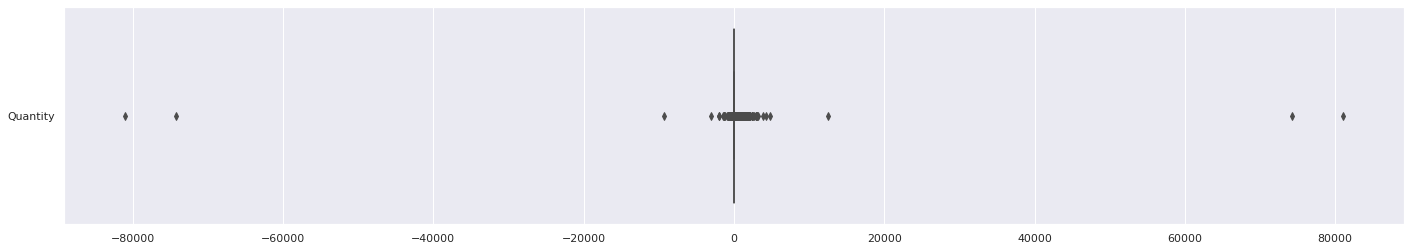

In [ ]:
quantity = pd.DataFrame(data['Quantity'])

f = plt.figure(figsize=(24, 4))
sb.boxplot(data = quantity, orient = "h")

In [ ]:
cleared_data = data[data['Quantity']>0]
cleared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527765 entries, 0 to 527764
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  527765 non-null  object 
 1   Date           527765 non-null  object 
 2   ProductNo      527765 non-null  object 
 3   ProductName    527765 non-null  object 
 4   Price          527765 non-null  float64
 5   Quantity       527765 non-null  int64  
 6   CustomerNo     527764 non-null  float64
 7   Country        527765 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.2+ MB


As we can see above, the number of entries has decreased from 536350 to 527765 meaning we have removed the canceled transactions data. <br>
We can also see from the boxplot below that all the negative values have been removed 

In [ ]:
quantity = pd.DataFrame(cleared_data['Quantity'])

f = plt.figure(figsize=(24, 4))
sb.boxplot(data = quantity, orient = "h")

### Remove rows with Nan values in any variable

We check if there are any more errors - NaN values

In [ ]:
for column in cleared_data:
  print(column + ' NaN values: ' + str(cleared_data[column].isnull().sum()))

We will remove all rows with Nan values, as they disturb the data

In [ ]:
cleared_data = cleared_data.dropna()

In [ ]:
cleared_data.head()

Now we do check if any left

In [ ]:
for column in cleared_data:
  print(column + ' NaN values: ' + str(cleared_data[column].isnull().sum()))

### Checking if all rows are in the wanted format

We will do one additional check to see whether there is no wrong information in the dataset. Using a loop and regular expressions we will see if all data is in the wanted format.

In [ ]:
import re # importing libarary for regular expressions
date_reg = "\d{4}-\d{2}-\d{2}"
productN_reg = "\d+[A-Z]?"
error = False
for index, row in cleared_data.iterrows():
  transactionN = row[0]
  date = row[1]
  productN = row[2]
  error = (not isinstance(transactionN, int)) \
  & (re.match(date_reg, date) is None) \
  & (re.match(productN_reg, productN) is None)
  if (error):
    print("Error")
    break

if (error == False):
  print("No Error")

No Error


As we can see, there is no error, so all rows are valid. We are not checking the other columns (ProductName, Price, Quantity, CustomerNo, Country) because we can see from the dataset .info() they are the correct type.

## 3. Exploratory Data Analysis on Cleaned Dataset

First we will begin by importing the essential Python Libraries. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from os.path import exists
sb.set() # set the default Seaborn style for graphics

# !pip install basemap
# !pip install basemap-data-hires
# from mpl_toolkits.basemap import Basemap
# import geopandas as gpd

Now we will import our dataset. <br>
This is the description of the dataset, as found on kaggle https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business <br>
1. TransactionNo (nominal): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
3. Date (numeric): the date when each transaction was generated.
4. ProductNo (nominal): a five or six-digit unique character used to identify a specific product.
5. Product (nominal): product/item name.
6. Price (numeric): the price of each product per unit in pound sterling (£).
7. Quantity (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
9. CustomerNo (nominal): a five-digit unique number that defines each customer.
10. Country (nominal): name of the country where the customer resides.

In [ ]:
cleared_data.head()

TransactionNo        Date ProductNo                          ProductName  \
0        536365  2018-12-01    85123A   Cream Hanging Heart T-Light Holder   
1        536365  2018-12-01     71053         White Moroccan Metal Lantern   
2        536365  2018-12-01    84406B       Cream Cupid Hearts Coat Hanger   
3        536365  2018-12-01    84029G  Knitted Union Flag Hot Water Bottle   
4        536365  2018-12-01    84029E        Red Woolly Hottie White Heart   

   Price  Quantity  CustomerNo         Country  
0   1.88         6     17850.0  United Kingdom  
1   2.01         6     17850.0  United Kingdom  
2   1.91         8     17850.0  United Kingdom  
3   2.01         6     17850.0  United Kingdom  
4   2.01         6     17850.0  United Kingdom

Now, we will check the shape of data to determine the number of columns and rows in the dataset

In [ ]:
print("Dimensions of Cleared Data : ", cleared_data.shape)

Dimensions of Cleared Data :  (527764, 8)


A quick inspection shows that there are : <br>
527764 rows <br>
=> There are 527764 transactions <br>
8 columns <br>
=> There are 8 variables in this data set for us to explore <br>
AFTER CLEANING

now let's take a look at the data types of the columns 

In [ ]:
print(cleared_data.dtypes)

TransactionNo     object
Date              object
ProductNo         object
ProductName       object
Price            float64
Quantity           int64
CustomerNo       float64
Country           object
dtype: object


Now, let's look at the buying patter trend over the entire year in months to have a rough idea of how frequent transactions occur within a 1 year timeframe

In [ ]:
data_trans_n = {}
current = []
for index, row in cleared_data.iterrows():
  date = row["Date"][:-3]
  tran = row["TransactionNo"]
  if date not in data_trans_n.keys():
    current = []
    current.append(tran)
    data_trans_n[date] = 1
  else:
    if tran not in current:
      data_trans_n[date] += 1
      current.append(tran)

print(data_trans_n)

{'2018-12': 1552, '2019-01': 1081, '2019-02': 1096, '2019-03': 1442, '2019-04': 1235, '2019-05': 1670, '2019-06': 1527, '2019-07': 1452, '2019-08': 1341, '2019-09': 1818, '2019-10': 2005, '2019-11': 2753, '2019-12': 818}


In [ ]:
time_series_data = pd.DataFrame({'months' : data_trans_n.keys() , 'transaction_no_Counts' : data_trans_n.values() })
time_series_data.head()

months  transaction_no_Counts
0  2018-12                   1552
1  2019-01                   1081
2  2019-02                   1096
3  2019-03                   1442
4  2019-04                   1235

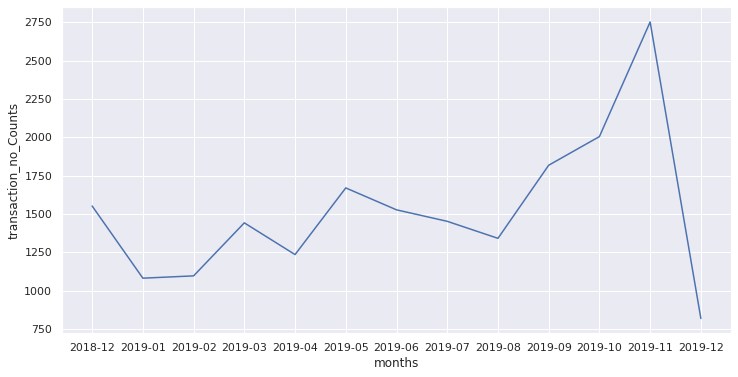

In [ ]:
from datetime import datetime

x = time_series_data['months'] # datetime
y = time_series_data['transaction_no_Counts'] # transaction counts 

plt.figure(figsize=(12,6))
# plt.plot(x, y)
sb.lineplot(x=x, y=y, ci=95) # confidence interval
plt.show()

From the Time Series Analysis, <br>
We can derive some predictive Analysis on Inventory Management <br>
We can see that there is an enormously large spike in November 2019 which makes sense because customers are usually preparing presents for Christmas presents during November. <br>
=> We can recommend the store to stock up on the months from september to november as there is an upward trend of transactions following from september to november. Especially on the month of november <br>
Thus, the store can prepare for the increase in demand from september to november 

Let's explore the price of range of the transactions 

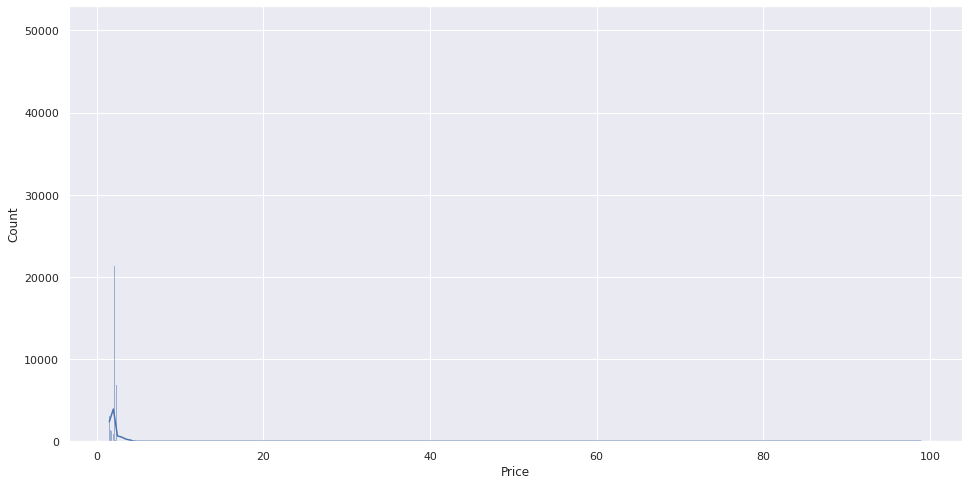

In [ ]:
f = plt.figure(figsize=(16, 8))
sb.histplot(cleared_data["Price"], kde = True)

We can see that the price of each product ranges from 0 to 100 sterlings. We can also see that the most freuqntly bought item is bought at around $3. But let's get the exact number 

In [ ]:
cleared_data["Price"].describe()

count    527764.000000
mean          1.987982
std           0.655688
min           1.500000
25%           1.690000
50%           1.810000
75%           2.120000
max          98.920000
Name: Price, dtype: float64

Now, we can clearly see that the price of the product that has been most frequently bought is at the price 1.81

Let's explore quantity, more specifically the quantity of each product per transaction

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


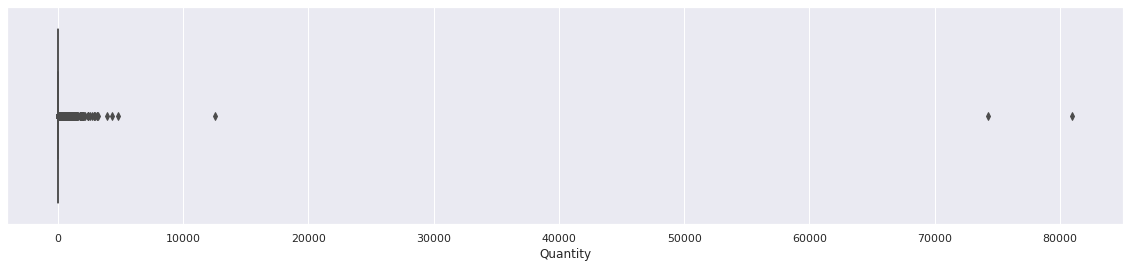

In [ ]:
f = plt.figure(figsize=(20, 4))
sb.boxplot(cleared_data['Quantity'], orient = "h")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


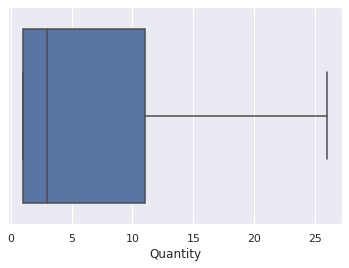

In [ ]:
sb.boxplot(cleared_data['Quantity'], orient = "h", showfliers = False)

Notice, how there is a huge difference in quantity after 10,000 <br>
This suggests that there is probably customer segmentation <br>
Namely, big customer vs small customer <br>
This leads to another sub question : <br>
How does the buying patterns differ from the big customers vs the small customers ? <br>
Thus, we have to split the dataset into small and big customers respectively in order to analyse the buying patters of both type of customers respectively

# 4. Splitting Retail Customers from Normal Customers

### Creating the template for the customers dataframe.

The first thing to do is to form a new table with rows - the customers and the columns - their variables.

The variables will be:
*   Average number of transactions per year.
*   Average transaction price.
*   Average quantity per transaction.
*   Average number of products per transaction.



In [ ]:
data_customers = pd.DataFrame(columns=["CustomerNo", "TranAvgY", "PriceAvg", "QuantityAvg", "NumberOfProd"])
cutomerNos = list(cleared_data["CustomerNo"].unique()) # list with all unique customer numbers
data_customers

Empty DataFrame
Columns: [CustomerNo, TranAvgY, PriceAvg, QuantityAvg, NumberOfProd]
Index: []

### Calculating the variables

First, we will make structures for customer, transaction and product to work easily with calculating the variables.

In [ ]:
class Customer():
  def __init__(self, id, transactions):
    self.id = id
    self.transactions = transactions

  def get_first_and_last_year(self):
    min = np.min([x.year for x in self.transactions.values()])
    max = np.max([x.year for x in self.transactions.values()])
    return (min, max)

class Transaction():
  def __init__(self, id, year, products):
    self.id = id
    self.year = year
    self.products = products

  def calculate_total_price(self):
    return sum([(x.price * x.quantity) for x in self.products.values()])

  def calculate_total_quantity(self):
    return sum([(x.quantity) for x in self.products.values()])

  def calculate_total_unique_products(self):
    return len(self.products)

class Product():
  def __init__(self, id, price, quantity, name):
    self.id = id
    self.price = price
    self.quantity = quantity
    self.name = name


Having the structures now we can calculate easily the variables we need for every customer. 

In [ ]:
customers = {}
for index, row in cleared_data.iterrows():
  customer = row['CustomerNo']
  tranNo = row['TransactionNo']
  date = row['Date']
  productId = row['ProductNo']
  productName = row['ProductName']
  price = int(row['Price'])
  quantity = int(row['Quantity'])
  if (customer not in customers.keys()):
    product = Product(productId, price, quantity, productName)
    transaction = Transaction(tranNo, int(date[0:4]), {productId: product})
    customers[customer] = (Customer(customer, {tranNo: transaction}))
  else:
    if tranNo not in customers[customer].transactions.keys():
      product = Product(productId, price, quantity, productName)
      transaction = Transaction(tranNo, int(date[0:4]), {productId: product})
      customers[customer].transactions[tranNo] = transaction
    else:
      if productId not in customers[customer].transactions[tranNo].products.keys():
        product = Product(productId, price, quantity, productName)
        customers[customer].transactions[tranNo].products[productId] = product
      else:
        customers[customer].transactions[tranNo].products[productId].quantity += quantity

### Creating the pandas DataFrame

In [ ]:
for cId, cust in customers.items():
  PriceAvg = sum([t.calculate_total_price() for t in cust.transactions.values()])/len(cust.transactions)
  QuantityAvg = sum([t.calculate_total_quantity() for t in cust.transactions.values()])/len(cust.transactions)
  NumberOfProd = sum([t.calculate_total_unique_products() for t in cust.transactions.values()])/len(cust.transactions)
  min_max_year = cust.get_first_and_last_year()
  TranAvgY = len(cust.transactions)/(min_max_year[1]-min_max_year[0]+1)
  data_customers = data_customers.append({"CustomerNo": int(cId), "TranAvgY": TranAvgY, "PriceAvg": np.round(PriceAvg,2), "QuantityAvg": np.round(QuantityAvg,2), "NumberOfProd": np.round(NumberOfProd,2)}, ignore_index=True)
data_customers

CustomerNo  TranAvgY  PriceAvg  QuantityAvg  NumberOfProd
0        17850.0      34.0     71.24        50.26          8.62
1        13047.0       4.5    193.89       154.44         19.00
2        12583.0       7.5    373.20       335.20         15.47
3        13748.0       2.5     93.80        87.80          5.60
4        15100.0       1.5     80.00        26.67          1.00
...          ...       ...       ...          ...           ...
4713     16238.0       1.0   1219.00       691.00        203.00
4714     15431.0       1.0     14.00        14.00          7.00
4715     14435.0       1.0      2.00         2.00          2.00
4716     15439.0       1.0   2404.00      1747.00        634.00
4717     12713.0       1.0    572.00       505.00         37.00

[4718 rows x 5 columns]

In [ ]:
data_customers.to_csv('data_customers.csv', index=True)

### Exploring the new DataFrame


First we will look at more information about the DataFrame

In [ ]:
data_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4718 entries, 0 to 4717
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerNo    4718 non-null   float64
 1   TranAvgY      4718 non-null   float64
 2   PriceAvg      4718 non-null   float64
 3   QuantityAvg   4718 non-null   float64
 4   NumberOfProd  4718 non-null   float64
dtypes: float64(5)
memory usage: 184.4 KB


Now, let's visualise the distribution of the variables

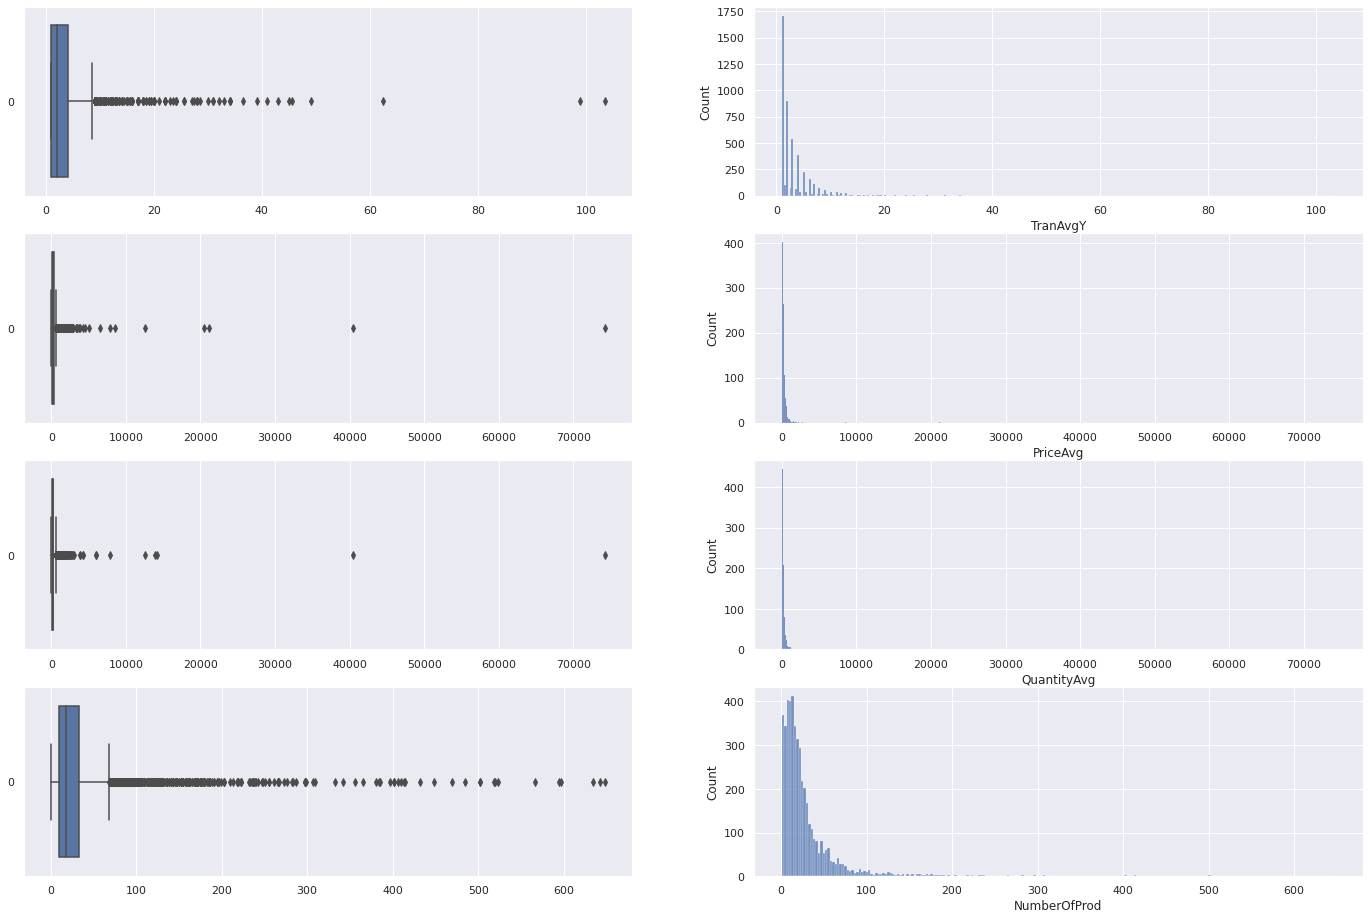

In [ ]:
exp_data_customers = pd.DataFrame(data_customers[["TranAvgY", "PriceAvg", "QuantityAvg", "NumberOfProd"]])

f, axes = plt.subplots(4, 2, figsize=(24, 16))

count = 0
for var in exp_data_customers:
    sb.boxplot(data = exp_data_customers[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = exp_data_customers[var], ax = axes[count,1])
    count += 1

Now, we will get the statistical summary 

In [ ]:
exp_data_customers.describe().round(2)

TranAvgY  PriceAvg  QuantityAvg  NumberOfProd
count   4718.00   4718.00      4718.00       4718.00
mean       3.27    314.30       271.35         31.58
std        4.26   1362.40      1312.10         49.60
min        1.00      1.00         1.00          1.00
25%        1.00    106.58        88.00         10.00
50%        2.00    188.67       162.98         18.50
75%        4.00    317.00       283.10         33.50
max      103.50  74215.00     74215.00        648.00

From the summary statistics, we can see that the <br>
Minimum transaction is 1, while the maximum transaction is 103 <br>
=> So how do we determine whether a customer is an individual customer or a retailer ? <br>
=> we look at the median as it is not affected by the average transactions of the retailers to roughly identify the individual customers <br>
Similarly, we will look at the **median** for the other 3 variables as well <br>

median of No. of Transaction = 2 <br>
median of Price = 106.58 <br>
median of Quantity = 162.98 <br>
median of No. of products = 18.50 <br>

Then from there, we will calculate the outliers using the formula <br>
outliers = Q3 + 1.5 IQR <br>
This is to get a rough idea of what the outliers within this distribution are, but of course, we have to define ourselves of what makes sense to be an individual customer vs a retail customer 

Which gives <br>
outlier for No. of Transaction = 8.5 <br>
outlier for Price per transcation = 632.63 <br>
outlier for Quantity per transaction = 575.75 <br>
outlier for No. of products per transaction = 68.75 <br>

These values are justifiable as it makes sense that :<br>
1. Outliers for No. of Transaction > 8.5 <br>
If we apply a scale = 1.5
Using our domain knowledge, this makes sense as it is possible for a small customer to buy products from the gift shop maximum 8 times a year 
A big customer would make more than 8 purchases in a year (data is from 1 dec 2018 - 9 dec 2019). 
*(to change or removed) In fact, we can even increase the scale of the outlier formula to 2 to get 10 purchases in a year and it would stil make sense to be considered an individual customer. Now, let's scale the formula even more to 7 and we get 25 puchases in a year. Which means that the customer makes a transaction at twice once a month, which is possible. Thus, we will consider a retail customer to be those who make more than 25 transactions in a year*<br>
<br>
Applying the scale = 2 for the rest of the variables, we get : <br>
<br>
2. Outliers for Price > 737.84 <br>

This makes sense because small customers may purchase big ticket items like a monitor etc... or multiple items in a transaction <br>
3. Outliers for Quantity per transaction > 673.3 <br>
This makes sense because customers may buy cheap items like " Set/6 Red Spotty Paper Plates " to host a mass event <br>
4. Outliers for No. of products per transaction > 33.5 <br>
We apply scale = 0 
If we apply the scale = 2 for No. of products which is 80.5 which does not make sense for an small customer to buy that many different No. of products in 1 transaction, so we will reduce the scale back to 1.5 and we will get 68.75 products in a transaction which still does not make sense. So, we scale it down to 0 and we get Q3 which is 33.5 
This makes sense because an individual customer may buy variants of the same kind of product like " Alarm Clock Bakelike Pink " , "Alarm Clock Bakelike Red" , " Alarm Clock Bakelike Green ". Thus the same product but different colors for example <br>

Side Note for the scale of Outlier formula  :
Well, as you might have guessed, the number (here 1.5, hereinafter scale) clearly controls the sensitivity of the range and hence the decision rule. A bigger scale would make the outlier(s) to be considered as data point(s) while a smaller one would make some of the data point(s) to be perceived as outlier(s). And we’re quite sure, none of these cases is desirable.

In [ ]:
tran_req = 8.5
price_req = 737.84
quantity_req = 673.3
n_product_req =  33.5

### Splitting the customers
 

Having the definition of a small and big customer, we can separate them.

In [ ]:
big_customers = data_customers.loc[(data_customers['TranAvgY']>tran_req) | (data_customers['PriceAvg']>price_req) | (data_customers['QuantityAvg']> quantity_req) | ((data_customers['NumberOfProd']>n_product_req))]
small_customers = data_customers.loc[~((data_customers['TranAvgY']>tran_req) | (data_customers['PriceAvg']>price_req) | (data_customers['QuantityAvg']> quantity_req) | ((data_customers['NumberOfProd']>n_product_req)))]

small_ids = list(small_customers['CustomerNo'].unique())
big_ids = list(big_customers['CustomerNo'].unique())
print(big_ids)

[17850.0, 14688.0, 15311.0, 16029.0, 16250.0, 17511.0, 13408.0, 13767.0, 15862.0, 15513.0, 17908.0, 17920.0, 12838.0, 13694.0, 14849.0, 17968.0, 17897.0, 17377.0, 14729.0, 12748.0, 15012.0, 15525.0, 14237.0, 12433.0, 14911.0, 17841.0, 12921.0, 13468.0, 16274.0, 13777.0, 18229.0, 14606.0, 13576.0, 17544.0, 16592.0, 15752.0, 17017.0, 13418.0, 18041.0, 16244.0, 16546.0, 14060.0, 15923.0, 15544.0, 17381.0, 15827.0, 14180.0, 16916.0, 17964.0, 17802.0, 17976.0, 14449.0, 17581.0, 15061.0, 15574.0, 14031.0, 12971.0, 17757.0, 13798.0, 16754.0, 14395.0, 15093.0, 17961.0, 13370.0, 12841.0, 17967.0, 14156.0, 14680.0, 12557.0, 16013.0, 17949.0, 17787.0, 12682.0, 14723.0, 17954.0, 15769.0, 14396.0, 13081.0, 15545.0, 16864.0, 12876.0, 14982.0, 17243.0, 15465.0, 13089.0, 16033.0, 13838.0, 18055.0, 18109.0, 13069.0, 16241.0, 15708.0, 16839.0, 16168.0, 16931.0, 16814.0, 14813.0, 12567.0, 16353.0, 18118.0, 13506.0, 18156.0, 16983.0, 17059.0, 16327.0, 15880.0, 16718.0, 15808.0, 14527.0, 14161.0, 15023.0, 

In [ ]:
print("Number of small customers: " + str(len(small_ids)))
print("Number of big customers: " + str(len(big_ids)))

Number of small customers: 3228
Number of big customers: 1490


In [ ]:
b_customers = {}
s_customers = {}
big_customers_ids = list(big_customers['CustomerNo'].unique())
for key, value in customers.items():
  if key in big_customers_ids:
    b_customers[key] = value
  else:
    s_customers[key] = value

We have splitted the customers into 2 dictionaries and we will form dataframes from these dictionaries.

### Forming the 2 dataFrames for different customers

In [ ]:
if exists('/content/s_customers_data_transactions.csv'):
  pass
else:
  b_customers_data_transactions = pd.DataFrame(columns = cleared_data.columns)
  s_customers_data_transactions = pd.DataFrame(columns = cleared_data.columns)
  prev_id = None
  prev_frame = None
  for index, row in cleared_data.iterrows():
    curr_cust_id = row['CustomerNo']
    if curr_cust_id == prev_id:
      if prev_frame == 0:
        b_customers_data_transactions = b_customers_data_transactions.append(row)
      else:
        s_customers_data_transactions = s_customers_data_transactions.append(row)
    elif curr_cust_id in big_ids:
      b_customers_data_transactions = b_customers_data_transactions.append(row)
      prev_frame = 0
    else:
      s_customers_data_transactions = s_customers_data_transactions.append(row)
      prev_frame = 1
    prev_id = curr_cust_id

  b_customers_data_transactions.to_csv('b_customers_data_transactions.csv', index=False)
  s_customers_data_transactions.to_csv('s_customers_data_transactions.csv', index=False)

In [ ]:
s_tran_data = pd.read_csv("/content/s_customers_data_transactions.csv", delimiter=None, 
                    header ='infer', names=None, 
                    index_col=None, usecols=None, squeeze=False, engine=None)

b_tran_data = pd.read_csv("/content/b_customers_data_transactions.csv", delimiter=None, 
                    header ='infer', names=None, 
                    index_col=None, usecols=None, squeeze=False, engine=None)

In [ ]:
s_tran_data.shape

(162594, 8)

In [ ]:
b_tran_data.shape


(365170, 8)

Despite small customers being 2 times more than the big retailers, eventually we can see that the number of transactions for the big customers is 2 times more than the one for small retailers. We can conclude that on average a big customer has 4 times more transaction than a smaller one.

Text(0.5, 1.0, "Ratio of small to big customers' transactions")

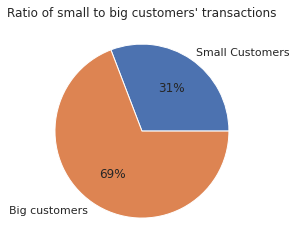

In [ ]:
plt.pie([s_tran_data.shape[0], b_tran_data.shape[0]], labels = ['Small Customers', 'Big customers'], autopct='%.0f%%')
plt.title("Ratio of small to big customers' transactions")

# 5. Choosing the Top Products

### Checking for the top products

First, we have to check all unique values in the ProductName column.

In [ ]:
s_unique_product_names = s_tran_data["ProductName"].unique()
print(len(s_unique_product_names))

3434


In [ ]:
b_unique_product_names = b_tran_data["ProductName"].unique()
print(len(b_unique_product_names))

3687


*As* we have 3434 and 3687 unique products, it will be good to lower their number, that is why we will choose the top 50 products based on the number of occurrences in the transactions.

In [ ]:
x = s_tran_data['ProductName'].value_counts()
s_top_50_products = {}
cnt = 0
for key, value in x.items():
  cnt+=1
  s_top_50_products[key] = value
  if (cnt == 50):
    break
print(s_top_50_products)

{'Cream Hanging Heart T-Light Holder': 985, 'Regency Cakestand 3 Tier': 844, 'Assorted Colour Bird Ornament': 750, 'Jumbo Bag Red Retrospot': 713, 'Party Bunting': 672, 'Set Of 3 Cake Tins Pantry Design': 541, 'Natural Slate Heart Chalkboard': 525, "Paper Chain Kit 50'S Christmas": 494, 'Heart Of Wicker Small': 481, 'Lunch Bag Red Retrospot': 444, 'Rex Cash+Carry Jumbo Shopper': 430, 'Jumbo Bag Vintage Doily': 429, 'Baking Set 9 Piece Retrospot': 429, 'Rabbit Night Light': 427, 'Spotty Bunting': 426, 'Pack Of 72 Retrospot Cake Cases': 421, 'Wooden Picture Frame White Finish': 418, 'Jam Making Set Printed': 409, 'Lunch Bag Suki Design': 407, 'Jam Making Set With Jars': 406, 'Alarm Clock Bakelike Red': 403, 'Victorian Glass Hanging T-Light': 402, 'Jumbo Shopper Vintage Red Paisley': 401, 'Popcorn Holder': 400, 'Retrospot Tea Set Ceramic 11 Pc': 398, 'Jumbo Bag Pink Polkadot': 388, 'Wooden Frame Antique White': 386, 'Antique Silver T-Light Glass': 376, 'Roses Regency Teacup And Saucer': 3

In [ ]:
x = b_tran_data['ProductName'].value_counts()
b_top_50_products = {}
cnt = 0
for key, value in x.items():
  cnt+=1
  b_top_50_products[key] = value
  if (cnt == 50):
    break
print(b_top_50_products)

{'Jumbo Bag Red Retrospot': 1402, 'Cream Hanging Heart T-Light Holder': 1351, 'Regency Cakestand 3 Tier': 1175, 'Lunch Bag Red Retrospot': 1153, 'Party Bunting': 1036, 'Popcorn Holder': 1026, 'Lunch Bag Black Skull': 954, 'Pack Of 72 Retrospot Cake Cases': 952, 'Lunch Bag Suki Design': 921, 'Set Of 3 Cake Tins Pantry Design': 858, 'Jumbo Bag Pink Polkadot': 850, 'Jumbo Storage Bag Suki': 844, 'Jumbo Bag Vintage Doily': 820, 'Lunch Bag Spaceboy Design': 806, 'Lunch Bag Cars Blue': 805, 'Lunch Bag Pink Polkadot': 800, 'Recipe Box Pantry Yellow Design': 795, 'Jumbo Shopper Vintage Red Paisley': 790, 'Lunch Bag Apple Design': 783, 'Set Of 4 Pantry Jelly Moulds': 777, 'Lunch Bag Vintage Doily': 770, 'Red Retrospot Charlotte Bag': 765, 'Jam Making Set Printed': 760, 'Heart Of Wicker Small': 745, 'Assorted Colour Bird Ornament': 741, 'Spotty Bunting': 740, 'Lunch Bag Woodland': 738, 'Natural Slate Heart Chalkboard': 738, 'Jam Making Set With Jars': 736, 'Roses Regency Teacup And Saucer': 709,

### Finding the most correlated products

Now we have all the unique names of the top 50 products. We will use them as keys for a 2-dimensional dictionary where every cell will be the number of times productA has occurred with productB in the same transaction.

In [ ]:
s_mutual_occurences = {}
s_top_50_products_names = s_top_50_products.keys()
for productA in s_top_50_products_names:
  s_mutual_occurences[productA] = {}
  for productB in s_top_50_products_names:
    s_mutual_occurences[productA][productB] = 0

print(s_mutual_occurences)

b_mutual_occurences = {}
b_top_50_products_names = b_top_50_products.keys()
for productA in b_top_50_products_names:
  b_mutual_occurences[productA] = {}
  for productB in b_top_50_products_names:
    b_mutual_occurences[productA][productB] = 0

print(b_mutual_occurences)

{'Cream Hanging Heart T-Light Holder': {'Cream Hanging Heart T-Light Holder': 0, 'Regency Cakestand 3 Tier': 0, 'Assorted Colour Bird Ornament': 0, 'Jumbo Bag Red Retrospot': 0, 'Party Bunting': 0, 'Set Of 3 Cake Tins Pantry Design': 0, 'Natural Slate Heart Chalkboard': 0, "Paper Chain Kit 50'S Christmas": 0, 'Heart Of Wicker Small': 0, 'Lunch Bag Red Retrospot': 0, 'Rex Cash+Carry Jumbo Shopper': 0, 'Jumbo Bag Vintage Doily': 0, 'Baking Set 9 Piece Retrospot': 0, 'Rabbit Night Light': 0, 'Spotty Bunting': 0, 'Pack Of 72 Retrospot Cake Cases': 0, 'Wooden Picture Frame White Finish': 0, 'Jam Making Set Printed': 0, 'Lunch Bag Suki Design': 0, 'Jam Making Set With Jars': 0, 'Alarm Clock Bakelike Red': 0, 'Victorian Glass Hanging T-Light': 0, 'Jumbo Shopper Vintage Red Paisley': 0, 'Popcorn Holder': 0, 'Retrospot Tea Set Ceramic 11 Pc': 0, 'Jumbo Bag Pink Polkadot': 0, 'Wooden Frame Antique White': 0, 'Antique Silver T-Light Glass': 0, 'Roses Regency Teacup And Saucer': 0, 'Lunch Bag Blac

We have constructed the table with the occurrences of productA and productB in the same transaction. We have to fill it now.

First, we will create a dictionary with a key - the transaction number and a value - an array of the products in it.

In [ ]:
s_transactions = {}
for index, row in s_tran_data.iterrows():
  transaction_number = row[0]
  product_name = row[3]
  if product_name not in s_top_50_products_names:
    continue
  if transaction_number not in s_transactions.keys():
    s_transactions[transaction_number] = []
  s_transactions[transaction_number].append(product_name)
print(s_transactions)

b_transactions = {}
for index, row in b_tran_data.iterrows():
  transaction_number = row[0]
  product_name = row[3]
  if product_name not in b_top_50_products_names:
    continue
  if transaction_number not in b_transactions.keys():
    b_transactions[transaction_number] = []
  b_transactions[transaction_number].append(product_name)
print(b_transactions)

{536367: ['Assorted Colour Bird Ornament', 'Home Building Block Word'], 536368: ['Jam Making Set With Jars'], 536370: ['Alarm Clock Bakelike Red', 'Alarm Clock Bakelike Green'], 536371: ["Paper Chain Kit 50'S Christmas"], 536380: ['Jam Making Set Printed'], 536382: ['Jumbo Shopper Vintage Red Paisley', 'Alarm Clock Bakelike Green'], 536384: ['Natural Slate Heart Chalkboard', 'Heart Of Wicker Small', 'Heart Of Wicker Large'], 536385: ['Jam Making Set Printed', 'Jam Making Set With Jars'], 536389: ['Alarm Clock Bakelike Green', 'Alarm Clock Bakelike Red'], 536392: ['Assorted Colour Bird Ornament'], 536398: ['Chocolate Hot Water Bottle', 'Scottie Dog Hot Water Bottle'], 536400: ['Homemade Jam Scented Candles'], 536404: ['Heart Of Wicker Small', 'Popcorn Holder', 'Pack Of 72 Retrospot Cake Cases', 'Lunch Bag Suki Design', 'Lunch Bag Cars Blue', 'Lunch Bag Black Skull'], 536408: ['Victorian Glass Hanging T-Light', 'Assorted Colour Bird Ornament', 'Home Building Block Word', 'Pack Of 72 Retr

Now having the dictionary, we will use it to count the occurrences of productA and productB in the same transaction.

In [ ]:
for products_in_same_transaction in s_transactions.values():
  for productA in products_in_same_transaction:
    for productB in products_in_same_transaction:
      if productA == productB:
        continue
      s_mutual_occurences[productA][productB] +=1
print(s_mutual_occurences)

{'Cream Hanging Heart T-Light Holder': {'Cream Hanging Heart T-Light Holder': 0, 'Regency Cakestand 3 Tier': 114, 'Assorted Colour Bird Ornament': 147, 'Jumbo Bag Red Retrospot': 97, 'Party Bunting': 126, 'Set Of 3 Cake Tins Pantry Design': 80, 'Natural Slate Heart Chalkboard': 118, "Paper Chain Kit 50'S Christmas": 36, 'Heart Of Wicker Small': 103, 'Lunch Bag Red Retrospot': 55, 'Rex Cash+Carry Jumbo Shopper': 74, 'Jumbo Bag Vintage Doily': 44, 'Baking Set 9 Piece Retrospot': 39, 'Rabbit Night Light': 25, 'Spotty Bunting': 51, 'Pack Of 72 Retrospot Cake Cases': 38, 'Wooden Picture Frame White Finish': 124, 'Jam Making Set Printed': 49, 'Lunch Bag Suki Design': 55, 'Jam Making Set With Jars': 51, 'Alarm Clock Bakelike Red': 33, 'Victorian Glass Hanging T-Light': 73, 'Jumbo Shopper Vintage Red Paisley': 58, 'Popcorn Holder': 42, 'Retrospot Tea Set Ceramic 11 Pc': 44, 'Jumbo Bag Pink Polkadot': 55, 'Wooden Frame Antique White': 109, 'Antique Silver T-Light Glass': 58, 'Roses Regency Teac

In [ ]:
for products_in_same_transaction in b_transactions.values():
  for productA in products_in_same_transaction:
    for productB in products_in_same_transaction:
      if productA == productB:
        continue
      b_mutual_occurences[productA][productB] +=1
print(b_mutual_occurences)

{'Jumbo Bag Red Retrospot': {'Jumbo Bag Red Retrospot': 0, 'Cream Hanging Heart T-Light Holder': 375, 'Regency Cakestand 3 Tier': 249, 'Lunch Bag Red Retrospot': 466, 'Party Bunting': 287, 'Popcorn Holder': 329, 'Lunch Bag Black Skull': 327, 'Pack Of 72 Retrospot Cake Cases': 318, 'Lunch Bag Suki Design': 329, 'Set Of 3 Cake Tins Pantry Design': 262, 'Jumbo Bag Pink Polkadot': 620, 'Jumbo Storage Bag Suki': 546, 'Jumbo Bag Vintage Doily': 432, 'Lunch Bag Spaceboy Design': 233, 'Lunch Bag Cars Blue': 261, 'Lunch Bag Pink Polkadot': 299, 'Recipe Box Pantry Yellow Design': 265, 'Jumbo Shopper Vintage Red Paisley': 478, 'Lunch Bag Apple Design': 256, 'Set Of 4 Pantry Jelly Moulds': 247, 'Lunch Bag Vintage Doily': 256, 'Red Retrospot Charlotte Bag': 357, 'Jam Making Set Printed': 260, 'Heart Of Wicker Small': 218, 'Assorted Colour Bird Ornament': 140, 'Spotty Bunting': 198, 'Lunch Bag Woodland': 249, 'Natural Slate Heart Chalkboard': 267, 'Jam Making Set With Jars': 252, 'Roses Regency Teac

Now have the number of occurences for each product A and B. We will visualize them in better-looking table

In [ ]:
for row in s_mutual_occurences.values():
  for column in row.values():
    print(str(column)+' '*(2+5-len(str(column))), end='')
  print()

0      114    147    97     126    80     118    36     103    55     74     44     39     25     51     38     124    49     55     51     33     73     58     42     44     55     109    58     47     53     53     121    55     47     32     32     46     38     48     44     22     43     33     104    54     33     28     54     44     36     
114    0      111    48     121    98     55     42     46     42     29     42     47     39     46     75     51     62     43     68     69     56     37     52     37     26     52     35     195    40     36     39     43     47     60     26     24     25     44     184    30     68     29     35     42     39     111    28     39     29     
147    111    0      33     103    60     78     38     57     38     46     34     53     25     66     43     63     39     32     46     41     83     25     44     34     19     57     62     52     31     22     64     36     30     39     38     15     24     19     47     30     36     32  

In [ ]:
for row in b_mutual_occurences.values():
  for column in row.values():
    print(str(column)+' '*(2+5-len(str(column))), end='')
  print()

0      375    249    466    287    329    327    318    329    262    620    546    432    233    261    299    265    478    256    247    256    357    260    218    140    198    249    267    252    223    252    184    245    432    222    136    435    278    215    201    193    209    205    150    421    275    208    325    197    205    
375    0      267    301    282    300    245    263    241    256    219    272    183    201    212    238    264    224    163    250    181    211    234    320    197    184    197    329    235    223    208    191    246    198    301    148    212    211    205    215    204    230    217    148    206    198    206    164    172    196    
249    267    0      247    289    227    209    302    197    220    111    165    136    181    183    156    236    153    151    193    131    236    241    156    169    157    169    186    227    356    174    156    360    120    129    229    125    212    137    206    183    173    150 

Having this 50x50 correlation matrix for the simultaneous occurrences of 2 products, we have to choose the products with the highest simultaneous occurrences.

In [ ]:
s_simultaneous_occur = {}
for productA in s_mutual_occurences.keys():
  for productB in s_mutual_occurences[productA].keys():
    if productA != productB:
      key = tuple([productA, productB])
      alt_key = tuple([productB, productA]) # alternative key used to compare if (A,B) or (B,A)
      value = s_mutual_occurences[productA][productB]
      if key not in s_simultaneous_occur.keys():
        if alt_key not in s_simultaneous_occur.keys():
          s_simultaneous_occur[key] = value
print(s_simultaneous_occur)

b_simultaneous_occur = {}
for productA in b_mutual_occurences.keys():
  for productB in b_mutual_occurences[productA].keys():
    if productA != productB:
      key = tuple([productA, productB])
      alt_key = tuple([productB, productA]) # alternative key used to compare if (A,B) or (B,A)
      value = b_mutual_occurences[productA][productB]
      if key not in b_simultaneous_occur.keys():
        if alt_key not in b_simultaneous_occur.keys():
          b_simultaneous_occur[key] = value
print(b_simultaneous_occur)

{('Cream Hanging Heart T-Light Holder', 'Regency Cakestand 3 Tier'): 114, ('Cream Hanging Heart T-Light Holder', 'Assorted Colour Bird Ornament'): 147, ('Cream Hanging Heart T-Light Holder', 'Jumbo Bag Red Retrospot'): 97, ('Cream Hanging Heart T-Light Holder', 'Party Bunting'): 126, ('Cream Hanging Heart T-Light Holder', 'Set Of 3 Cake Tins Pantry Design'): 80, ('Cream Hanging Heart T-Light Holder', 'Natural Slate Heart Chalkboard'): 118, ('Cream Hanging Heart T-Light Holder', "Paper Chain Kit 50'S Christmas"): 36, ('Cream Hanging Heart T-Light Holder', 'Heart Of Wicker Small'): 103, ('Cream Hanging Heart T-Light Holder', 'Lunch Bag Red Retrospot'): 55, ('Cream Hanging Heart T-Light Holder', 'Rex Cash+Carry Jumbo Shopper'): 74, ('Cream Hanging Heart T-Light Holder', 'Jumbo Bag Vintage Doily'): 44, ('Cream Hanging Heart T-Light Holder', 'Baking Set 9 Piece Retrospot'): 39, ('Cream Hanging Heart T-Light Holder', 'Rabbit Night Light'): 25, ('Cream Hanging Heart T-Light Holder', 'Spotty B

Now having all the number of times A has occurred with B, we will sort them and choose the top 15 most correlated pairs.

In [ ]:
s_sorted_sim_occur = dict(sorted(s_simultaneous_occur.items(), key=lambda item: -item[1]))
print(s_sorted_sim_occur)

{('Alarm Clock Bakelike Red', 'Alarm Clock Bakelike Green'): 263, ('Roses Regency Teacup And Saucer', 'Green Regency Teacup And Saucer'): 257, ('Jumbo Bag Red Retrospot', 'Jumbo Bag Pink Polkadot'): 243, ('Jumbo Bag Red Retrospot', 'Jumbo Shopper Vintage Red Paisley'): 216, ("Paper Chain Kit 50'S Christmas", 'Paper Chain Kit Vintage Christmas'): 212, ('Wooden Picture Frame White Finish', 'Wooden Frame Antique White'): 210, ('Jumbo Bag Red Retrospot', 'Jumbo Storage Bag Suki'): 201, ('Regency Cakestand 3 Tier', 'Roses Regency Teacup And Saucer'): 195, ('Regency Cakestand 3 Tier', 'Green Regency Teacup And Saucer'): 184, ('Lunch Bag Red Retrospot', 'Lunch Bag Suki Design'): 180, ('Lunch Bag Suki Design', 'Lunch Bag Cars Blue'): 174, ('Jumbo Shopper Vintage Red Paisley', 'Jumbo Storage Bag Suki'): 172, ('Heart Of Wicker Small', 'Heart Of Wicker Large'): 171, ('Lunch Bag Red Retrospot', 'Lunch Bag Black Skull'): 167, ('Lunch Bag Suki Design', 'Lunch Bag Black Skull'): 165, ('Lunch Bag Suki

In [ ]:
b_sorted_sim_occur = dict(sorted(b_simultaneous_occur.items(), key=lambda item: -item[1]))
print(b_sorted_sim_occur)

{('Jumbo Bag Red Retrospot', 'Jumbo Bag Pink Polkadot'): 620, ('Roses Regency Teacup And Saucer', 'Green Regency Teacup And Saucer'): 588, ('Jumbo Bag Red Retrospot', 'Jumbo Storage Bag Suki'): 546, ('Lunch Bag Red Retrospot', 'Lunch Bag Black Skull'): 532, ('Lunch Bag Red Retrospot', 'Lunch Bag Suki Design'): 515, ('Lunch Bag Red Retrospot', 'Lunch Bag Pink Polkadot'): 496, ('Lunch Bag Black Skull', 'Lunch Bag Suki Design'): 482, ('Jumbo Bag Red Retrospot', 'Jumbo Shopper Vintage Red Paisley'): 478, ('Jumbo Bag Red Retrospot', 'Lunch Bag Red Retrospot'): 466, ('Lunch Bag Black Skull', 'Lunch Bag Pink Polkadot'): 455, ('Lunch Bag Red Retrospot', 'Lunch Bag Spaceboy Design'): 450, ('Jumbo Bag Red Retrospot', 'Jumbo Bag Baroque Black White'): 435, ('Lunch Bag Black Skull', 'Lunch Bag Cars Blue'): 435, ('Jumbo Bag Red Retrospot', 'Jumbo Bag Vintage Doily'): 432, ('Jumbo Bag Red Retrospot', 'Jumbo Bag Apples'): 432, ('Lunch Bag Red Retrospot', 'Lunch Bag Woodland'): 431, ('Lunch Bag Red Re

We have sorted the products by their mutual occurrence. We will print and choose the top 15 pairs.

In [ ]:
cnt = 0;
s_corr_products = []
for key in s_sorted_sim_occur.keys():
  cnt +=1
  print(key)
  s_corr_products.append(key[0])
  s_corr_products.append(key[1])
  if (cnt==15):
    break

('Alarm Clock Bakelike Red', 'Alarm Clock Bakelike Green')
('Roses Regency Teacup And Saucer', 'Green Regency Teacup And Saucer')
('Jumbo Bag Red Retrospot', 'Jumbo Bag Pink Polkadot')
('Jumbo Bag Red Retrospot', 'Jumbo Shopper Vintage Red Paisley')
("Paper Chain Kit 50'S Christmas", 'Paper Chain Kit Vintage Christmas')
('Wooden Picture Frame White Finish', 'Wooden Frame Antique White')
('Jumbo Bag Red Retrospot', 'Jumbo Storage Bag Suki')
('Regency Cakestand 3 Tier', 'Roses Regency Teacup And Saucer')
('Regency Cakestand 3 Tier', 'Green Regency Teacup And Saucer')
('Lunch Bag Red Retrospot', 'Lunch Bag Suki Design')
('Lunch Bag Suki Design', 'Lunch Bag Cars Blue')
('Jumbo Shopper Vintage Red Paisley', 'Jumbo Storage Bag Suki')
('Heart Of Wicker Small', 'Heart Of Wicker Large')
('Lunch Bag Red Retrospot', 'Lunch Bag Black Skull')
('Lunch Bag Suki Design', 'Lunch Bag Black Skull')


In [ ]:
cnt = 0;
b_corr_products = []
for key in b_sorted_sim_occur.keys():
  cnt +=1
  print(key)
  b_corr_products.append(key[0])
  b_corr_products.append(key[1])
  if (cnt==15):
    break

('Jumbo Bag Red Retrospot', 'Jumbo Bag Pink Polkadot')
('Roses Regency Teacup And Saucer', 'Green Regency Teacup And Saucer')
('Jumbo Bag Red Retrospot', 'Jumbo Storage Bag Suki')
('Lunch Bag Red Retrospot', 'Lunch Bag Black Skull')
('Lunch Bag Red Retrospot', 'Lunch Bag Suki Design')
('Lunch Bag Red Retrospot', 'Lunch Bag Pink Polkadot')
('Lunch Bag Black Skull', 'Lunch Bag Suki Design')
('Jumbo Bag Red Retrospot', 'Jumbo Shopper Vintage Red Paisley')
('Jumbo Bag Red Retrospot', 'Lunch Bag Red Retrospot')
('Lunch Bag Black Skull', 'Lunch Bag Pink Polkadot')
('Lunch Bag Red Retrospot', 'Lunch Bag Spaceboy Design')
('Jumbo Bag Red Retrospot', 'Jumbo Bag Baroque Black White')
('Lunch Bag Black Skull', 'Lunch Bag Cars Blue')
('Jumbo Bag Red Retrospot', 'Jumbo Bag Vintage Doily')
('Jumbo Bag Red Retrospot', 'Jumbo Bag Apples')


So the unique individual products in these top 15 pairs are:

In [ ]:
cnt = 1
s_unique_corr_products = set(s_corr_products)
for x in s_unique_corr_products:
  print(str(cnt)+')'+' '*(3-len(str(cnt)))+str(x))
  cnt += 1

1)  Jumbo Bag Red Retrospot
2)  Lunch Bag Red Retrospot
3)  Heart Of Wicker Small
4)  Roses Regency Teacup And Saucer
5)  Heart Of Wicker Large
6)  Lunch Bag Suki Design
7)  Lunch Bag Cars Blue
8)  Regency Cakestand 3 Tier
9)  Paper Chain Kit Vintage Christmas
10) Paper Chain Kit 50'S Christmas
11) Wooden Frame Antique White
12) Green Regency Teacup And Saucer
13) Jumbo Storage Bag Suki
14) Wooden Picture Frame White Finish
15) Alarm Clock Bakelike Red
16) Lunch Bag Black Skull
17) Alarm Clock Bakelike Green
18) Jumbo Bag Pink Polkadot
19) Jumbo Shopper Vintage Red Paisley


In [ ]:
cnt = 1
b_unique_corr_products = set(b_corr_products)
for x in b_unique_corr_products:
  print(str(cnt)+')'+' '*(3-len(str(cnt)))+str(x))
  cnt += 1

1)  Green Regency Teacup And Saucer
2)  Lunch Bag Spaceboy Design
3)  Jumbo Storage Bag Suki
4)  Jumbo Bag Red Retrospot
5)  Lunch Bag Red Retrospot
6)  Jumbo Bag Vintage Doily
7)  Lunch Bag Suki Design
8)  Lunch Bag Cars Blue
9)  Lunch Bag Pink Polkadot
10) Lunch Bag Black Skull
11) Jumbo Bag Baroque Black White
12) Jumbo Bag Pink Polkadot
13) Roses Regency Teacup And Saucer
14) Jumbo Bag Apples
15) Jumbo Shopper Vintage Red Paisley


### Building the new dataframe required for the Machine Learning part

This data frame has to be constructed from rows - each transaction and columns - products in the transaction.

In [ ]:
for key, value in s_transactions.items():
  wanted_prod = []
  for product in value:
    if product in s_unique_corr_products:
      wanted_prod.append(product)
  s_transactions[key] = wanted_prod
print(s_transactions)

for key, value in b_transactions.items():
  wanted_prod = []
  for product in value:
    if product in b_unique_corr_products:
      wanted_prod.append(product)
  b_transactions[key] = wanted_prod
print(b_transactions)

{536367: [], 536368: [], 536370: ['Alarm Clock Bakelike Red', 'Alarm Clock Bakelike Green'], 536371: ["Paper Chain Kit 50'S Christmas"], 536380: [], 536382: ['Jumbo Shopper Vintage Red Paisley', 'Alarm Clock Bakelike Green'], 536384: ['Heart Of Wicker Small', 'Heart Of Wicker Large'], 536385: [], 536389: ['Alarm Clock Bakelike Green', 'Alarm Clock Bakelike Red'], 536392: [], 536398: [], 536400: [], 536404: ['Heart Of Wicker Small', 'Lunch Bag Suki Design', 'Lunch Bag Cars Blue', 'Lunch Bag Black Skull'], 536408: [], 536416: ['Wooden Frame Antique White'], 536420: [], 536423: [], 536425: [], 536477: ['Regency Cakestand 3 Tier', 'Jumbo Shopper Vintage Red Paisley'], 536502: ['Regency Cakestand 3 Tier'], 536523: ['Roses Regency Teacup And Saucer'], 536524: ['Green Regency Teacup And Saucer'], 536525: ['Regency Cakestand 3 Tier'], 536526: ['Jumbo Bag Red Retrospot', 'Jumbo Shopper Vintage Red Paisley'], 536527: [], 536530: ['Roses Regency Teacup And Saucer', 'Regency Cakestand 3 Tier', 'Ju

In [ ]:
for key, value in b_transactions.items():
  if len(value) != len(set(value)):
    print(key)
    print(value)

for key, value in s_transactions.items():
  if len(value) != len(set(value)):
    print(key)
    print(value)

536528
['Jumbo Shopper Vintage Red Paisley', 'Jumbo Shopper Vintage Red Paisley']
536863
['Lunch Bag Black Skull', 'Lunch Bag Red Retrospot', 'Lunch Bag Pink Polkadot', 'Lunch Bag Spaceboy Design', 'Lunch Bag Black Skull', 'Lunch Bag Suki Design', 'Lunch Bag Pink Polkadot', 'Lunch Bag Suki Design']
536981
['Jumbo Shopper Vintage Red Paisley', 'Jumbo Shopper Vintage Red Paisley']
537154
['Jumbo Bag Red Retrospot', 'Jumbo Bag Baroque Black White', 'Jumbo Bag Baroque Black White']
537399
['Jumbo Storage Bag Suki', 'Jumbo Bag Baroque Black White', 'Jumbo Storage Bag Suki']
537793
['Jumbo Storage Bag Suki', 'Jumbo Shopper Vintage Red Paisley', 'Jumbo Bag Baroque Black White', 'Jumbo Bag Pink Polkadot', 'Jumbo Bag Red Retrospot', 'Lunch Bag Pink Polkadot', 'Lunch Bag Suki Design', 'Lunch Bag Red Retrospot', 'Lunch Bag Spaceboy Design', 'Lunch Bag Pink Polkadot', 'Lunch Bag Black Skull', 'Lunch Bag Red Retrospot']
538035
['Jumbo Shopper Vintage Red Paisley', 'Jumbo Bag Red Retrospot', 'Lunch 

**We can see that many transactions include multiple occurances of the same product in them. We have to remove these occurances because they disturb the data.**

In [ ]:
for key, value in s_transactions.items():
  wanted_prod = []
  for product in value:
    if product in s_unique_corr_products:
      wanted_prod.append(product)
  wanted_prod = set(wanted_prod)
  wanted_prod = list(wanted_prod)
  s_transactions[key] = wanted_prod
print(s_transactions)

{536367: [], 536368: [], 536370: ['Alarm Clock Bakelike Red', 'Alarm Clock Bakelike Green'], 536371: ["Paper Chain Kit 50'S Christmas"], 536380: [], 536382: ['Alarm Clock Bakelike Green', 'Jumbo Shopper Vintage Red Paisley'], 536384: ['Heart Of Wicker Small', 'Heart Of Wicker Large'], 536385: [], 536389: ['Alarm Clock Bakelike Red', 'Alarm Clock Bakelike Green'], 536392: [], 536398: [], 536400: [], 536404: ['Heart Of Wicker Small', 'Lunch Bag Cars Blue', 'Lunch Bag Suki Design', 'Lunch Bag Black Skull'], 536408: [], 536416: ['Wooden Frame Antique White'], 536420: [], 536423: [], 536425: [], 536477: ['Regency Cakestand 3 Tier', 'Jumbo Shopper Vintage Red Paisley'], 536502: ['Regency Cakestand 3 Tier'], 536523: ['Roses Regency Teacup And Saucer'], 536524: ['Green Regency Teacup And Saucer'], 536525: ['Regency Cakestand 3 Tier'], 536526: ['Jumbo Bag Red Retrospot', 'Jumbo Shopper Vintage Red Paisley'], 536527: [], 536530: ['Regency Cakestand 3 Tier', 'Roses Regency Teacup And Saucer', 'Ju

In [ ]:
for key, value in b_transactions.items():
  wanted_prod = []
  for product in value:
    if product in b_unique_corr_products:
      wanted_prod.append(product)
  wanted_prod = set(wanted_prod)
  wanted_prod = list(wanted_prod)
  b_transactions[key] = wanted_prod
print(b_transactions)

{536365: [], 536373: [], 536375: [], 536378: ['Jumbo Storage Bag Suki', 'Jumbo Bag Pink Polkadot', 'Lunch Bag Red Retrospot', 'Jumbo Bag Baroque Black White'], 536381: ['Jumbo Shopper Vintage Red Paisley'], 536386: ['Jumbo Bag Red Retrospot', 'Jumbo Bag Baroque Black White'], 536388: [], 536390: ['Jumbo Bag Red Retrospot'], 536394: [], 536395: [], 536396: [], 536401: ['Lunch Bag Red Retrospot', 'Lunch Bag Spaceboy Design', 'Lunch Bag Pink Polkadot'], 536402: [], 536406: [], 536409: ['Jumbo Bag Red Retrospot', 'Jumbo Storage Bag Suki'], 536412: ['Lunch Bag Spaceboy Design', 'Lunch Bag Red Retrospot', 'Lunch Bag Suki Design', 'Lunch Bag Cars Blue', 'Lunch Bag Black Skull'], 536415: [], 536460: [], 536464: ['Jumbo Bag Red Retrospot', 'Jumbo Bag Pink Polkadot', 'Jumbo Bag Baroque Black White'], 536466: [], 536488: [], 536500: [], 536520: [], 536522: ['Jumbo Bag Red Retrospot', 'Jumbo Storage Bag Suki'], 536528: ['Jumbo Shopper Vintage Red Paisley'], 536532: [], 536540: [], 536557: [], 5365

In [ ]:
for key, value in b_transactions.items():
  if len(value) != len(set(value)):
    print(key)
    print(value)

for key, value in s_transactions.items():
  if len(value) != len(set(value)):
    print(key)
    print(value)

The empty transactions are not needed as they do not include the analyzed products, so we just remove them.

In [ ]:
s_keys_to_be_removed = []
for key, value in s_transactions.items():
  if value == []:
    s_keys_to_be_removed.append(key)

for x in s_keys_to_be_removed:
  del s_transactions[x]
print(s_transactions)

{536370: ['Alarm Clock Bakelike Red', 'Alarm Clock Bakelike Green'], 536371: ["Paper Chain Kit 50'S Christmas"], 536382: ['Alarm Clock Bakelike Green', 'Jumbo Shopper Vintage Red Paisley'], 536384: ['Heart Of Wicker Small', 'Heart Of Wicker Large'], 536389: ['Alarm Clock Bakelike Red', 'Alarm Clock Bakelike Green'], 536404: ['Heart Of Wicker Small', 'Lunch Bag Cars Blue', 'Lunch Bag Suki Design', 'Lunch Bag Black Skull'], 536416: ['Wooden Frame Antique White'], 536477: ['Regency Cakestand 3 Tier', 'Jumbo Shopper Vintage Red Paisley'], 536502: ['Regency Cakestand 3 Tier'], 536523: ['Roses Regency Teacup And Saucer'], 536524: ['Green Regency Teacup And Saucer'], 536525: ['Regency Cakestand 3 Tier'], 536526: ['Jumbo Bag Red Retrospot', 'Jumbo Shopper Vintage Red Paisley'], 536530: ['Regency Cakestand 3 Tier', 'Roses Regency Teacup And Saucer', 'Jumbo Shopper Vintage Red Paisley'], 536531: ["Paper Chain Kit 50'S Christmas", 'Alarm Clock Bakelike Red', 'Paper Chain Kit Vintage Christmas', '

In [ ]:
b_keys_to_be_removed = []
for key, value in b_transactions.items():
  if value == []:
    b_keys_to_be_removed.append(key)

for x in b_keys_to_be_removed:
  del b_transactions[x]
print(b_transactions)


{536378: ['Jumbo Storage Bag Suki', 'Jumbo Bag Pink Polkadot', 'Lunch Bag Red Retrospot', 'Jumbo Bag Baroque Black White'], 536381: ['Jumbo Shopper Vintage Red Paisley'], 536386: ['Jumbo Bag Red Retrospot', 'Jumbo Bag Baroque Black White'], 536390: ['Jumbo Bag Red Retrospot'], 536401: ['Lunch Bag Red Retrospot', 'Lunch Bag Spaceboy Design', 'Lunch Bag Pink Polkadot'], 536409: ['Jumbo Bag Red Retrospot', 'Jumbo Storage Bag Suki'], 536412: ['Lunch Bag Spaceboy Design', 'Lunch Bag Red Retrospot', 'Lunch Bag Suki Design', 'Lunch Bag Cars Blue', 'Lunch Bag Black Skull'], 536464: ['Jumbo Bag Red Retrospot', 'Jumbo Bag Pink Polkadot', 'Jumbo Bag Baroque Black White'], 536522: ['Jumbo Bag Red Retrospot', 'Jumbo Storage Bag Suki'], 536528: ['Jumbo Shopper Vintage Red Paisley'], 536575: ['Jumbo Bag Red Retrospot'], 536576: ['Jumbo Bag Red Retrospot', 'Lunch Bag Black Skull'], 536577: ['Lunch Bag Red Retrospot'], 536579: ['Lunch Bag Black Skull'], 536581: ['Jumbo Bag Red Retrospot'], 536591: ['Ju

We are checking if there are some repeated products in a transaction.

Now we can create the new dataframe.

In [ ]:
s_ml_data = pd.concat([pd.DataFrame([set(s_corr_products)]), pd.DataFrame(s_transactions.values())], axis=0, ignore_index=True)
s_ml_data.head()

0                                  1   \
0         Jumbo Bag Red Retrospot            Lunch Bag Red Retrospot   
1        Alarm Clock Bakelike Red         Alarm Clock Bakelike Green   
2  Paper Chain Kit 50'S Christmas                               None   
3      Alarm Clock Bakelike Green  Jumbo Shopper Vintage Red Paisley   
4           Heart Of Wicker Small              Heart Of Wicker Large   

                      2                                3   \
0  Heart Of Wicker Small  Roses Regency Teacup And Saucer   
1                   None                             None   
2                   None                             None   
3                   None                             None   
4                   None                             None   

                      4                      5                    6   \
0  Heart Of Wicker Large  Lunch Bag Suki Design  Lunch Bag Cars Blue   
1                   None                   None                 None   
2                   None                   None                 None   
3                   None                   None                 None   
4                   None                   None                 None   

                         7                                  8   \
0  Regency Cakestand 3 Tier  Paper Chain Kit Vintage Christmas   
1                      None                               None   
2                      None                               None   
3                      None                               None   
4                      None                               None   

                               9                           10  \
0  Paper Chain Kit 50'S Christmas  Wooden Frame Antique White   
1                             NaN                         NaN   
2                             NaN                         NaN   
3                             NaN                         NaN   
4                             NaN                         NaN   

                                11                      12  \
0  Green Regency Teacup And Saucer  Jumbo Storage Bag Suki   
1                              NaN                     NaN   
2                              NaN                     NaN   
3                              NaN                     NaN   
4                              NaN                     NaN   

                                  13                        14  \
0  Wooden Picture Frame White Finish  Alarm Clock Bakelike Red   
1                                NaN                       NaN   
2                                NaN                       NaN   
3                                NaN                       NaN   
4                                NaN                       NaN   

                      15                          16                       17  \
0  Lunch Bag Black Skull  Alarm Clock Bakelike Green  Jumbo Bag Pink Polkadot   
1                    NaN                         NaN                      NaN   
2                    NaN                         NaN                      NaN   
3                    NaN                         NaN                      NaN   
4                    NaN                         NaN                      NaN   

                                  18  
0  Jumbo Shopper Vintage Red Paisley  
1                                NaN  
2                                NaN  
3                                NaN  
4                                NaN

In [ ]:
b_ml_data = pd.concat([pd.DataFrame([set(b_corr_products)]), pd.DataFrame(b_transactions.values())], axis=0, ignore_index=True)
b_ml_data.head()

0                              1   \
0    Green Regency Teacup And Saucer      Lunch Bag Spaceboy Design   
1             Jumbo Storage Bag Suki        Jumbo Bag Pink Polkadot   
2  Jumbo Shopper Vintage Red Paisley                           None   
3            Jumbo Bag Red Retrospot  Jumbo Bag Baroque Black White   
4            Jumbo Bag Red Retrospot                           None   

                        2                              3   \
0   Jumbo Storage Bag Suki        Jumbo Bag Red Retrospot   
1  Lunch Bag Red Retrospot  Jumbo Bag Baroque Black White   
2                     None                           None   
3                     None                           None   
4                     None                           None   

                        4                        5                      6   \
0  Lunch Bag Red Retrospot  Jumbo Bag Vintage Doily  Lunch Bag Suki Design   
1                     None                     None                   None   
2                     None                     None                   None   
3                     None                     None                   None   
4                     None                     None                   None   

                    7                        8                      9   \
0  Lunch Bag Cars Blue  Lunch Bag Pink Polkadot  Lunch Bag Black Skull   
1                 None                     None                   None   
2                 None                     None                   None   
3                 None                     None                   None   
4                 None                     None                   None   

                              10                       11  \
0  Jumbo Bag Baroque Black White  Jumbo Bag Pink Polkadot   
1                           None                     None   
2                           None                     None   
3                           None                     None   
4                           None                     None   

                                12                13  \
0  Roses Regency Teacup And Saucer  Jumbo Bag Apples   
1                             None              None   
2                             None              None   
3                             None              None   
4                             None              None   

                                  14  
0  Jumbo Shopper Vintage Red Paisley  
1                               None  
2                               None  
3                               None  
4                               None

We have created the new dataframe and will also export it as a CSV file in the next line of code.

In [ ]:
s_ml_data.to_csv('s_ml_data.csv', index=False, header=False)
b_ml_data.to_csv('b_ml_data.csv', index=False, header=False)

### Creating 0/1 table for the transactions

Creating the format of the table

In [ ]:
s_01_table = pd.DataFrame(columns = s_unique_corr_products)
b_01_table = pd.DataFrame(columns = b_unique_corr_products)

Filling the table

In [ ]:
if exists('/content/s_01_table.csv'):
  pass
else:
  for index, row in s_ml_data.iterrows():
    new_row = {}
    for name in s_unique_corr_products:
      new_row[name] = 0
    for i in range(len(s_ml_data.columns)):
      prod = row[i]
      if prod == None:
        break
      new_row[prod] = 1
    s_01_table = s_01_table.append(new_row, ignore_index = True)

In [ ]:
if exists('/content/b_01_table.csv'):
  pass
else:
  for index, row in b_ml_data.iterrows():
    new_row = {}
    for name in b_unique_corr_products:
      new_row[name] = 0
    for i in range(len(b_ml_data.columns)):
      prod = row[i]
      if prod == None:
        break
      new_row[prod] = 1
    b_01_table = b_01_table.append(new_row, ignore_index = True)

In [ ]:
print(s_01_table.shape)
print(b_01_table.shape)

(4005, 20)
(3802, 15)


In [ ]:
s_01_table.to_csv('s_01_table.csv', index=True)
b_01_table.to_csv('b_01_table.csv', index=True)

# 6. Machine Learning Data Preparation

We will be using Association rule mining as the technique is used to unveil the association between items, where the items we purchase are denoted as X->Y. We have decided to use Apriori algorithm to generate association rules.

In [ ]:
pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=41bd3cd3299c519a1527e9698da7b3a186d2fb54d952f0d68b21a0eeda744fce
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


We will then install the relevant packages and libraries that we need for this algorithm

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
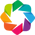

In [ ]:
#Basic necessary Libraries
import numpy as np
import pandas as pd

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import altair as alt
import plotly.express as px
from wordcloud import WordCloud,STOPWORDS
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

#Apriori libraries 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Import the transaction encoder function from mlxtend
from mlxtend.preprocessing import TransactionEncoder

#parallel plot
  
from pandas.plotting import parallel_coordinates

We will first import our small and big dataset

In [ ]:
small_store_data = pd.read_csv('s_ml_data.csv')

In [ ]:
small_store_data

Jumbo Bag Red Retrospot            Lunch Bag Red Retrospot  \
0              Alarm Clock Bakelike Red         Alarm Clock Bakelike Green   
1        Paper Chain Kit 50'S Christmas                                NaN   
2            Alarm Clock Bakelike Green  Jumbo Shopper Vintage Red Paisley   
3                 Heart Of Wicker Small              Heart Of Wicker Large   
4              Alarm Clock Bakelike Red         Alarm Clock Bakelike Green   
...                                 ...                                ...   
3999    Green Regency Teacup And Saucer  Wooden Picture Frame White Finish   
4000              Heart Of Wicker Small                                NaN   
4001  Jumbo Shopper Vintage Red Paisley                                NaN   
4002     Paper Chain Kit 50'S Christmas           Alarm Clock Bakelike Red   
4003           Alarm Clock Bakelike Red         Alarm Clock Bakelike Green   

                  Heart Of Wicker Small  Roses Regency Teacup And Saucer  \
0                                   NaN                              NaN   
1                                   NaN                              NaN   
2                                   NaN                              NaN   
3                                   NaN                              NaN   
4                                   NaN                              NaN   
...                                 ...                              ...   
3999           Regency Cakestand 3 Tier  Roses Regency Teacup And Saucer   
4000                                NaN                              NaN   
4001                                NaN                              NaN   
4002  Paper Chain Kit Vintage Christmas          Jumbo Bag Red Retrospot   
4003                                NaN                              NaN   

           Heart Of Wicker Large Lunch Bag Suki Design Lunch Bag Cars Blue  \
0                            NaN                   NaN                 NaN   
1                            NaN                   NaN                 NaN   
2                            NaN                   NaN                 NaN   
3                            NaN                   NaN                 NaN   
4                            NaN                   NaN                 NaN   
...                          ...                   ...                 ...   
3999  Wooden Frame Antique White                   NaN                 NaN   
4000                         NaN                   NaN                 NaN   
4001                         NaN                   NaN                 NaN   
4002                         NaN                   NaN                 NaN   
4003                         NaN                   NaN                 NaN   

     Regency Cakestand 3 Tier Paper Chain Kit Vintage Christmas  \
0                         NaN                               NaN   
1                         NaN                               NaN   
2                         NaN                               NaN   
3                         NaN                               NaN   
4                         NaN                               NaN   
...                       ...                               ...   
3999                      NaN                               NaN   
4000                      NaN                               NaN   
4001                      NaN                               NaN   
4002                      NaN                               NaN   
4003                      NaN                               NaN   

      Paper Chain Kit 50'S Christmas  Wooden Frame Antique White  \
0                                NaN                         NaN   
1                                NaN                         NaN   
2                                NaN                         NaN   
3                                NaN                         NaN   
4                                NaN                         NaN   
...             

In [ ]:
big_store_data = pd.read_csv('b_ml_data.csv')

The Apriori library we are going to use requires our dataset to be in the form of a list of lists.
Currently we have data in the form of a pandas dataframe. To convert our pandas dataframe into a list of lists, we execute the following code:

In [ ]:
transactions = []
for i in range(0, len(small_store_data)):
    transactions.append([str(small_store_data.values[i,j]) for j in range(0, len(small_store_data.columns))])


In [ ]:
b_transactions = []
for i in range(0, len(big_store_data)):
    b_transactions.append([str(big_store_data.values[i,j]) for j in range(0, len(big_store_data.columns))])

We then use an encoder our database transaction data in form of a Python list of lists into a NumPy array. This array format is needed for typical machine learning APIs.

In [ ]:
# Instantiate transaction encoder and identify unique items
encoder = TransactionEncoder().fit(transactions)
b_encoder = TransactionEncoder().fit(b_transactions)

# One-hot encode transactions
onehot = encoder.transform(transactions)
b_onehot = b_encoder.transform(b_transactions)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_).drop('nan', axis=1)
b_onehot = pd.DataFrame(b_onehot, columns = b_encoder.columns_).drop('nan', axis=1)

In [ ]:
onehot

Alarm Clock Bakelike Green  Alarm Clock Bakelike Red  \
0                           True                      True   
1                           True                      True   
2                          False                     False   
3                           True                     False   
4                          False                     False   
...                          ...                       ...   
4000                       False                     False   
4001                       False                     False   
4002                       False                     False   
4003                       False                      True   
4004                        True                      True   

      Green Regency Teacup And Saucer  Heart Of Wicker Large  \
0                                True                   True   
1                               False                  False   
2                               False                  False   
3                               False                  False   
4                               False                   True   
...                               ...                    ...   
4000                             True                  False   
4001                            False                  False   
4002                            False                  False   
4003                            False                  False   
4004                            False                  False   

      Heart Of Wicker Small  Jumbo Bag Pink Polkadot  Jumbo Bag Red Retrospot  \
0                      True                     True                     True   
1                     False                    False                    False   
2                     False                    False                    False   
3                     False                    False                    False   
4                      True                    False                    False   
...                     ...                      ...                      ...   
4000                  False                    False                    False   
4001                   True                    False                    False   
4002                  False                    False                    False   
4003                  False                    False                     True   
4004                  False                    False                    False   

      Jumbo Shopper Vintage Red Paisley  Jumbo Storage Bag Suki  \
0                                  True                    True   
1                                 False                   False   
2                                 False                   False   
3                                  True                   False   
4                                 False                   False   
...                                 ...                     ...   
4000                              False                   False   
4001                              False                   False   
4002                               True                   False   
4003                              False                   False   
4004                              False                   False   

      Lunch Bag Black Skull  Lunch Bag Cars Blue  Lunch Bag Red Retrospot  \
0                      True                 True                     True   
1                     False                False                    False   
2                     False                False                    False   
3                     False                False                    False   
4                     False                False                    False   
...                     ...                  ...                      ...   
4000                  False                False                    False   
4001                  False                False                    False   
4002                 

In our configurations, we will work in a support of 0.02 and a minimum threshold of 3 for the lift.

Since we know that our left-hand side has two items, then our question is which item is more likely to be added to the basket? Hence, we set the max_len as 3 as we want to compare 3 variables.

In [ ]:
#Apriori- Support using 0.025
frequent_itemsets = apriori(onehot,  min_support = 0.025, max_len  = 3, use_colnames=True)
b_frequent_itemsets = apriori(b_onehot, min_support = 0.025, max_len = 3, use_colnames=True)

#Associaton rules-using lift using minimum 3
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3)
b_rules = association_rules(b_frequent_itemsets, metric="lift", min_threshold=3)

This is a dynamic function to customize rules. In this example, we will only show the rules that have a lift of more than 5 and confidence more than 0.2.

In [ ]:
#Customizable function to change the lift and confidence
def rules_mod(rules,lift,confidence):
    '''rules_mod is a function to control the rules 
    based on lift and confidence threshold'''
    return rules[ (rules['lift'] >= lift) &
      (rules['confidence'] >= confidence) ]


In [ ]:
rules_mod(rules,4,0.2)

antecedents  \
0                        (Alarm Clock Bakelike Green)   
1                          (Alarm Clock Bakelike Red)   
2                   (Green Regency Teacup And Saucer)   
3                   (Roses Regency Teacup And Saucer)   
10                           (Jumbo Storage Bag Suki)   
11                          (Jumbo Bag Pink Polkadot)   
16                (Jumbo Shopper Vintage Red Paisley)   
17                           (Jumbo Storage Bag Suki)   
24                            (Lunch Bag Suki Design)   
25                            (Lunch Bag Black Skull)   
28                            (Lunch Bag Suki Design)   
29                              (Lunch Bag Cars Blue)   
30                            (Lunch Bag Suki Design)   
31                          (Lunch Bag Red Retrospot)   
32                   (Paper Chain Kit 50'S Christmas)   
33                (Paper Chain Kit Vintage Christmas)   
34                       (Wooden Frame Antique White)   
35                (Wooden Picture Frame White Finish)   
36  (Regency Cakestand 3 Tier, Green Regency Teacu...   
37  (Regency Cakestand 3 Tier, Roses Regency Teacu...   
38                  (Green Regency Teacup And Saucer)   
39                  (Roses Regency Teacup And Saucer)   
40  (Jumbo Shopper Vintage Red Paisley, Jumbo Bag ...   
41  (Jumbo Shopper Vintage Red Paisley, Jumbo Bag ...   
42  (Jumbo Bag Red Retrospot, Jumbo Bag Pink Polka...   
43                (Jumbo Shopper Vintage Red Paisley)   
45                          (Jumbo Bag Pink Polkadot)   
46  (Jumbo Bag Red Retrospot, Jumbo Storage Bag Suki)   
47  (Jumbo Bag Red Retrospot, Jumbo Bag Pink Polka...   
48  (Jumbo Storage Bag Suki, Jumbo Bag Pink Polkadot)   
50                           (Jumbo Storage Bag Suki)   
51                          (Jumbo Bag Pink Polkadot)   
52  (Jumbo Shopper Vintage Red Paisley, Jumbo Bag ...   
53  (Jumbo Shopper Vintage Red Paisley, Jumbo Stor...   
54  (Jumbo Bag Red Retrospot, Jumbo Storage Bag Suki)   
55                (Jumbo Shopper Vintage Red Paisley)   
57                           (Jumbo Storage Bag Suki)   

                                          consequents  antecedent support  \
0                          (Alarm Clock Bakelike Red)            0.088140   
1                        (Alarm Clock Bakelike Green)            0.099875   
2                   (Roses Regency Teacup And Saucer)            0.084145   
3                   (Green Regency Teacup And Saucer)            0.092135   
10                          (Jumbo Bag Pink Polkadot)            0.088390   
11                           (Jumbo Storage Bag Suki)            0.096629   
16                           (Jumbo Storage Bag Suki)            0.097878   
17                (Jumbo Shopper Vintage Red Paisley)            0.088390   
24                            (Lunch Bag Black Skull)            0.099875   
25                            (Lunch Bag Suki Design)            0.091136   
28                              (Lunch Bag Cars Blue)            0.099875   
29                            (Lunch Bag Suki Design)            0.091885   
30                          (Lunch Bag Red Retrospot)            0.099875   
31                            (Lunch Bag Suki Design)            0.109863   
32                (Paper Chain Kit Vintage Christmas)            0.121348   
33                   (Paper Chain Kit 50'S Christmas)            0.083146   
34                (Wooden Picture Frame White Finish)            0.095630   
35                       (Wooden Frame Antique White)            0.104120   
36                  (Roses Regency Teacup And Saucer)            0.044444   
37                  (Green Regency Teacup And Saucer)            0.046442   
38  (Regency Cakestand 3 Tier, Roses Regency Teacu...            0.084145   
39  (Regency Cakestand 3 Tier, Green Regency Teacu...            0.092135   
40                          (Jumbo Bag Pink Polkadot)            0.052684   
41                         

In [ ]:
rules_mod(b_rules,4,0.2)

antecedents  \
0                   (Green Regency Teacup And Saucer)   
1                   (Roses Regency Teacup And Saucer)   
2   (Jumbo Bag Apples, Green Regency Teacup And Sa...   
3   (Jumbo Bag Apples, Roses Regency Teacup And Sa...   
11  (Jumbo Bag Baroque Black White, Roses Regency ...   
14  (Green Regency Teacup And Saucer, Jumbo Bag Pi...   
15  (Roses Regency Teacup And Saucer, Jumbo Bag Pi...   
18  (Jumbo Bag Red Retrospot, Green Regency Teacup...   
19  (Jumbo Bag Red Retrospot, Roses Regency Teacup...   
20                  (Green Regency Teacup And Saucer)   
21                  (Roses Regency Teacup And Saucer)   
22  (Jumbo Shopper Vintage Red Paisley, Green Rege...   
23  (Jumbo Shopper Vintage Red Paisley, Roses Rege...   
26  (Jumbo Storage Bag Suki, Green Regency Teacup ...   
27  (Jumbo Storage Bag Suki, Roses Regency Teacup ...   
30  (Lunch Bag Red Retrospot, Roses Regency Teacup...   
31  (Green Regency Teacup And Saucer, Lunch Bag Re...   
34  (Lunch Bag Suki Design, Green Regency Teacup A...   
35  (Lunch Bag Suki Design, Roses Regency Teacup A...   

                                          consequents  antecedent support  \
0                   (Roses Regency Teacup And Saucer)            0.178853   
1                   (Green Regency Teacup And Saucer)            0.183851   
2                   (Roses Regency Teacup And Saucer)            0.038927   
3                   (Green Regency Teacup And Saucer)            0.037875   
11                  (Green Regency Teacup And Saucer)            0.035508   
14                  (Roses Regency Teacup And Saucer)            0.037349   
15                  (Green Regency Teacup And Saucer)            0.035245   
18                  (Roses Regency Teacup And Saucer)            0.063388   
19                  (Green Regency Teacup And Saucer)            0.057601   
20  (Jumbo Bag Red Retrospot, Roses Regency Teacup...            0.178853   
21  (Jumbo Bag Red Retrospot, Green Regency Teacup...            0.183851   
22                  (Roses Regency Teacup And Saucer)            0.044713   
23                  (Green Regency Teacup And Saucer)            0.042346   
26                  (Roses Regency Teacup And Saucer)            0.046028   
27                  (Green Regency Teacup And Saucer)            0.043924   
30                  (Green Regency Teacup And Saucer)            0.045765   
31                  (Roses Regency Teacup And Saucer)            0.045239   
34                  (Roses Regency Teacup And Saucer)            0.035771   
35                  (Green Regency Teacup And Saucer)            0.033140   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.183851  0.139663    0.780882  4.247374  0.106781    3.724709  
1             0.178853  0.139663    0.759657  4.247374  0.106781    3.416557  
2             0.183851  0.030247    0.777027  4.226405  0.023091    3.660306  
3             0.178853  0.030247    0.798611  4.465176  0.023473    4.077418  
11            0.178853  0.027354    0.770370  4.307277  0.021003    3.575962  
14            0.183851  0.027880    0.746479  4.060247  0.021013    3.219256  
15            0.178853  0.027880    0.791045  4.422871  0.021576    3.929774  
18            0.183851  0.046817    0.738589  4.017334  0.035164    3.122095  
19            0.178853  0.046817    0.812785  4.544427  0.036515    4.386125  
20            0.057601  0.046817    0.261765  4.544427  0.036515    1.276556  
21            0.063388  0.046817    0.254649  4.017334  0.035164    1.256607  
22            0.183851  0.034456    0.770588  4.191383  0.026235    3.557574  
23            0.178853  0.034456    0.813665  4.549342  0.026882    4.406821  
26            0.183851  0.034982    0.760000  4.133791  0.026519    3.400622  
27            0.178853  0.034982    0.796407  4.452853  0.027126    4.033280  
30            0.178853  0.035771    0.781609  4.370115  0.027585    3.759988  
31            0.1

However, the results in tabular form will not convey much insights into our algorithm so let us visualise the output using a heatmap and parallel plot.

# 7. Machine Learning Data Visualisation & Analysis

The parallel coordinates plot will allow us to visualize whether a relationship exist between an antecedent and consequent. We can think of it as a directed network diagram. The plot shows connections between  2  objects that are related and indicates the direction of the relationship. This visualisation is important as it visualize whether a rule exists, rather than the intensity of the rule according to some metric that we will show later on with a heatmap.

In [ ]:
# Function to convert rules to coordinates.
def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]



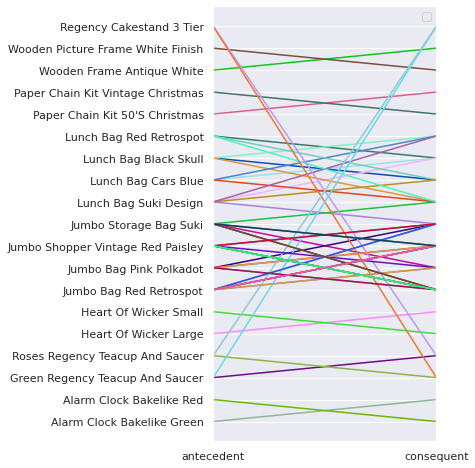

In [ ]:
# Convert rules into coordinates suitable for use in a parallel coordinates plot
s_coords = rules_to_coordinates(rules)

# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(s_coords, 'rule')
plt.legend([])
plt.grid(True)
plt.show()


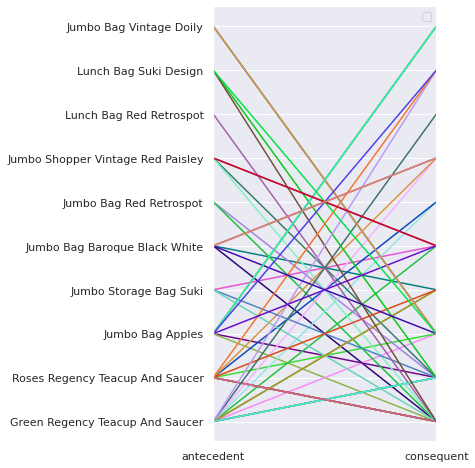

In [ ]:
b_coords = rules_to_coordinates(b_rules)

# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(b_coords, 'rule')
plt.legend([])
plt.grid(True)
plt.show()

**Small Customer** <br>

From the parallel coordinate plot, we can infer that if a small customers purchases a product, he/she will most likely buy a variety of product. <br>
Also, to increase the sales of the store, especially during the christmas season, we can see that this 2 items namely, Paper Chain Kit Vintage Christmas and Paper Chain Kit 50's Christmas are bought together during a transaction. <br> Thus, on the web-page, if a customer visits the Paper Chain Kit Vintage, we can recommend Paper Chain 50's Christmas.


**Big Customer**

From the parallel coordinate plot, notice that the rules are different from small customers set. The purchase of one product does not imply that he/she will most likely buy the variety of the product. In fact, the big customer will buy a different type of product. <br> For example, when a big customer buys Jumbo Bag Apples, they will likely buy a Lunch Bag Cars Blue. <br> Thus, the buying pattern of big customers are quite unpredictable.

For the big customers, given any of the top 15 products, if a big customer buys any products of this 15 products, he/she is most likely buy Green Regency Teacup and Saucer as we can see the total number of connections pointing to it.

In Summary, small customers would buy the same type of products but of different varieties while a big customer would buy different type of products.

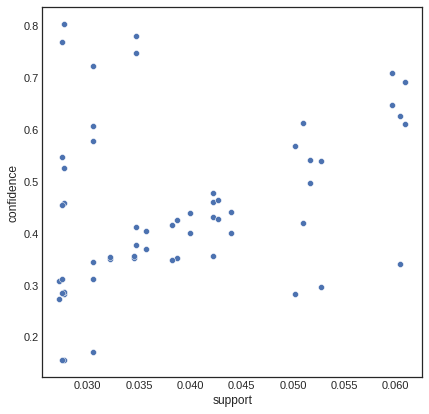

In [ ]:
#Setting up the style
plt.figure(figsize = (15, 15))
plt.style.use('seaborn-white')
#Plotting the relationship between the metrics
plt.subplot(221)
sns.scatterplot(x="support", y="confidence",data=rules)



Support describes of frequency of occurence, in layman term, the popularity of the itemset in a transaction. 

Confidence describes how likely an item B is purchased when item A is purchased.

From the scatter-plot, we can see that there is a linear relationship between confidence & support. This means that if I have a popular item A in X\N numbers of transactions, this X numbers of item A will have item B appearing in that transactions.

Thus, this shows that the dataset tells us that among the top 19 products, there is a strong relationship between confidence & support. This justifies the rules generated from the apriori algorithm 

For example, Lunch Bag Suki Design is one of the top 19 products which implies that it is one of the more frequently occured item amongst all the transaction. <br>

Within each of the transactions containing Lunch Bag Suki Design, a small customer is likely to buy Lunch Bag Cars Blue.



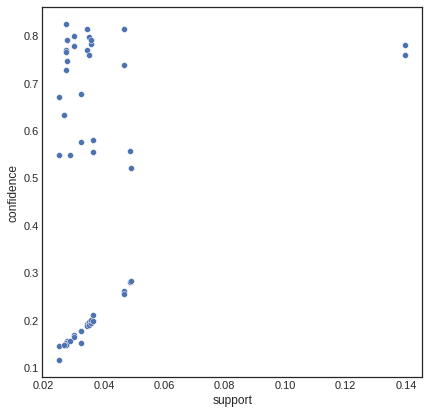

In [ ]:
#Setting up the style
plt.figure(figsize = (15, 15))
plt.style.use('seaborn-white')
#Plotting the relationship between the metrics
plt.subplot(221)
sns.scatterplot(x="support", y="confidence",data=b_rules)


From the scatter-plot, we can see that there is no linear relationship between confidence & support. 
For example, if Lunch Bag Suki Design (which is one of the top 15 products) which implies that it is one of the more frequently occured item amongst all the transaction. 

Thus, this shows that the dataset tells us that among the top 19 products, there is no linear relationship between confidence & support. This implies that the rules generated from the apriori algorithm are random or there's too many relationship from 1 item 
<br>

For example, Many of the top 19 products has a connection with Green Regency and Teacup Saucer. 
Thus, we cannot really see any strong relationship with any 2 items. For e.g. we can't really say for sure that if someone buys Lunch Bag Red Retrospot, he will buy a Green Regency and Teacup Saucer, but we can tell that there are many items that are picked along with Green Regency and Teacup Saucer in the same transaction 



Now, we will show how we can visualize the Market Basket Analysis Association Rules using Heatmap. Heatmaps help us understand a large number of rules between a small number of antecedents and consequents. We will show all the rules where the left-hand side consists of 2 items and we are looking for an extra one. The measurement is the lift.

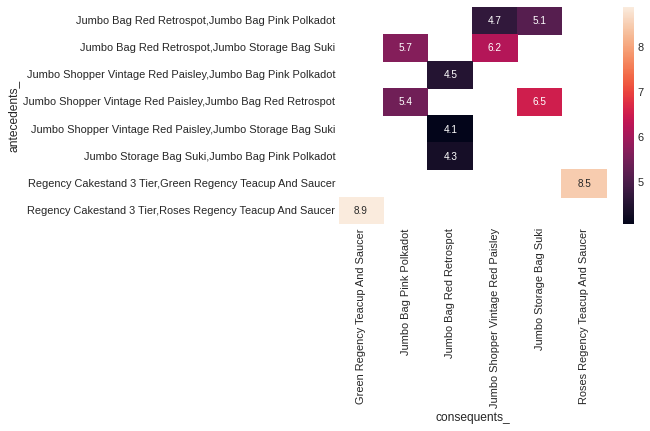

In [ ]:
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

A lift describes the importance of a rule by computing the ratio of confidence of the rule to the expected confidence of the rule.

We can conclude that Regency Cakestand 3 Tier and Roses Regency Teacup and Saucer -> Green Regency Teacup And Saucer is the highest importance because it has the highest lift.

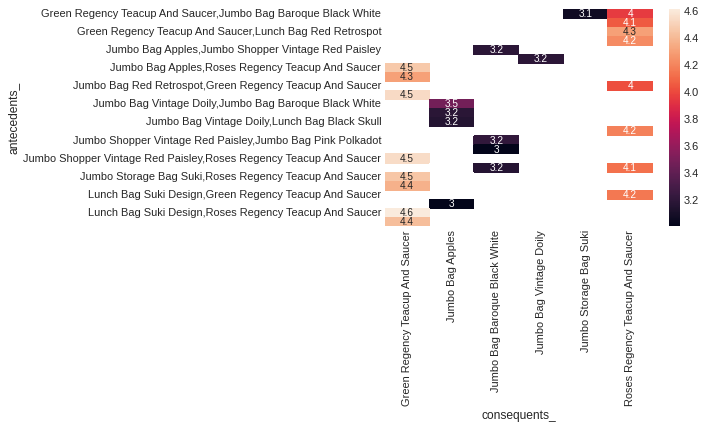

In [ ]:
b_rules['lhs items'] = b_rules['antecedents'].apply(lambda x:len(x) )
b_rules[b_rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
b_rules['antecedents_'] = b_rules['antecedents'].apply(lambda a: ','.join(list(a)))
b_rules['consequents_'] = b_rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = b_rules[b_rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

We can conclude that there is an unpredictable/no highest importance of a rule as the lifts lies within a range of 3.0 to 4.6.


# 8. Conclusion & Recommendation



Going back to our main Question : <br>
" Given that a customer has bought a certain product, are we able to recommended similar-related products to increase the sales of the store ? "
<br>
While exploring the data, we discovered some insights which generated sub-questions that branched off from the main question. <br>
The time - series analysis gave us an insight on inventory management : <br>
" How should we better prepare the store in terms of inventory management " <br>
Recommendations for the E-commerce store : <br>
Stock up from the month of september to November and especially during November so as to meet the increase in demands of the store's products during the holiday seasons. Which helps increase the sales of the store
<br>
Then as we further explore the data, we realised that the most frequently bought item was around the price of 1.18 sterlings. Which gave us a rough idea on the price range an average customer is willing to spend in the store <br>
Then we moved on to exploring the quantity of each product per transaction, which is where we noticed that there is a wide gap. This led us to think that the E-commerce store does not only have small individual customers but there are also big retail customers purchasing from the store. In other words, there is customer segmentation. This key insight led us to perform a more in depth approach in answering our main question. <br>
Then after applying our association rules, we realised were able to find out the buying patters of both small individual customers and big retail customers. This help us to answer our main question : <br>
" Given that a customer has bought a certain product, are we able to recommended similar-related products to increase the sales of the store ? "
<br>
Recommendations for the E-Commerce Store : <br>
For the small customers, we can put products of the same type but of different varities as recommendations. For e.g. If a customer visits the Paper Chain Kit Vintage, we can recommend Paper Chain 50's Christmas. This makes them more likely to buy the reommended item and hence increase the sales of the store. <br>
We can even be more targeted and look at all the products with rules and recommend the pair of products with connections. <br>
For the big customers, although we do not see any clear buying patterns, we are able to mass stock the products with the most connections. For e.g. Green Regency Teacup and Saucer clearly has many connections. Thus, we can increase the stockpile of such items through out the entire year to anticpate bulk purchases from big retail customers 
